# Fast GPU Hill Climbing Example
This notebook provides an example of hill climbing in Kaggle's "Exploring Mental Health Data" competition. There are many great libraries and packages to utilize for hill climbing and I encourage everyone to search them out (as alternatives to the example shown here). In this notebook, I use my old CPU code from Novozyme competition [here][2] and update it to use GPU and becomes much faster!

The competition metric is ACC (accuracy) which makes hill climbing on this metric difficult (and unstable). In this notebook, we hill climb using the proxy metric AUC (Area under ROC curve). Each OOF and Test Prediction files are probabilties and we first convert them all into log odds. This helps hill climbing combine them better. Afterward the result isn't probability calibrated so we find an optimal threshold to convert the result into predictions of 1's and 0's. There is a discussion about this notebook [here][3]

# Fully Explainable Model

In this notebook, we also create a simple fully explainable model. First we create 17 models each using 1 feature only. From these models, we can easily plot the relationship between each single feature and target prediction. Next we use `hill climbing` to combine these 17 models into a single submission. Hill climbing creates an ensemble from `pred = w1 * model1 + w2 * model2 + ... + w17 * model17`.

This model is fully explainable because given a test sample, we can inspect the value of each of the 17 column features. Then we can look at the plots below to see how each of these 17 features affect the prediction probability. Lastly we can look at the hill climbing weights `w1, w2, ..., w17` to see how the model combines the 17 probabilities into a single probability.

For example if `w1=0.50`, `w2 = 0.3`, and `w3 = 0.2`. This says that we take 50% of our final prediction `plot 1` and 30% of our final prediction from `plot 2` and 20% of our final prediction from `plot 3`. We can easily look at the involved plots and understand why the model is predicting what it is predicting!

# How To Improve
We can improve this notebook by modifying the individual models and/or modifying the hill climbing procedure. Additionally we can try other stage 2 meta models to combine the stage 1 base models (like Random Forest which I do in the original hill climbing notebook [here][2]). Finally, we can improve this notebook by adding our other models' OOF and Test Preds to the hill climbing procedure. For example, we can add our CatBoost OOF and Test Preds to this notebook and boost CV and LB! 

NOTE: When adding models use OOF and Test Preds which are probabilities between 0 and 1 (i.e. floats not integers). This is better than adding the submission.csv files which only contains 0's and 1's.

# UPDATE
* Version 1 - Uses vectorization and GPU to be faster than my old CPU hill climbing code.
* Version 2 - Is 6x faster than version 1. It uses GPU to compute multiple auc scores simultaneously!

# Load Data and Libraries

[1]: https://www.kaggle.com/competitions/playground-series-s4e11/discussion/543746
[2]: https://www.kaggle.com/code/cdeotte/public-lb-1st-place-solution
[3]: https://www.kaggle.com/competitions/playground-series-s4e11/discussion/546910

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd, numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv("/kaggle/input/playground-series-s4e11/train.csv")
print("Train shape:", train.shape, ", Target mean:", train.Depression.mean() )
train.head()

Train shape: (140700, 20) , Target mean: 0.18171286425017769


,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [2]:
test = pd.read_csv("/kaggle/input/playground-series-s4e11/test.csv")
print("Test shape:", test.shape)
#test.head()

Test shape: (93800, 19)


# Convert All Columns to Categorical
We convert all columns to categorical. This helps our simple TE (target encode) model work better for all columns. We convert all columns to strings. Additionally, nans get converted to the string "NAN" and rare values get converted to the string "RARE".

In [3]:
COL_TYPES = {}
FEATURES = list(train.columns[1:-1])

for i,c in enumerate(FEATURES):

    # FIND RARE VALUES
    COL_TYPES[c] = train[c].dtype
    tmp = train[c].value_counts().to_frame()
    tmp["encode"] = tmp.index.values
    tmp["encode"] = tmp["encode"].astype("str")
    tmp.loc[tmp["count"]<100,"encode"] = "RARE"

    # CONVERT ALL COLUMNS TO STRINGS
    train[c] = train[c].map(tmp.encode.to_dict())
    train[c] = train[c].fillna("NAN")

    # CONVERT ALL COLUMNS TO STRINGS
    test[c] = test[c].map(tmp.encode.to_dict())
    test[c] = test[c].fillna("NAN")

# Train 17 Single Feature Models
Each model is TE (Target Encoding) model. This model is simple. For a given categorical value, we predict the probability of the mean target for all those values in the train data. More info about TE in previous notebook [here][1] and [here][2]. And discussion [here][3]. Note that leak free generated TE (as demonstrated in first provided link) make great engineered features for ML and GBDT models. Or as shown here, they can be a stand alone model!

[1]: https://www.kaggle.com/code/cdeotte/rapids-cuml-lasso-lb-0-72500-cv-0-72800
[2]: https://www.kaggle.com/code/theoviel/explaining-and-accelerating-target-encoding
[3]: https://www.kaggle.com/competitions/playground-series-s4e9/discussion/533961

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score

In [5]:
#%%time
SMOOTH = 25
FOLDS = 5

rows = []
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
oofs = {}; preds = {}

print(f"Training {len(FEATURES)} single feature models...")
for j,COL in enumerate(FEATURES):
    print(f"{j+1}:{COL}",end="")
    
    oof = np.zeros(len(train))
    pred = np.zeros(len(test))
    data_test = test[[COL]].copy() 
    
    for i, (train_index, test_index) in enumerate(kf.split(train)):
    
        #print("#"*25)
        #print(f"### Fold {i+1}")
        #print("#"*25)
        
        data_train = train.loc[train_index,[COL,"Depression"]] 
        data_valid = train.loc[test_index,[COL,"Depression"]].copy() 

        # FIT TE (TARGET ENCODE) MODEL
        TE = data_train.groupby(COL).Depression.agg(["mean","count"])
        G_MEAN = data_train.Depression.mean()
        TE["smooth"] = (TE["mean"]*TE["count"] + G_MEAN*SMOOTH) / (TE["count"]+SMOOTH)

        # INFER OOF
        data_valid["oof"] = data_valid[COL].map(TE.smooth.to_dict())
        data_valid["oof"] = data_valid["oof"].fillna(G_MEAN)
        oof[test_index] = data_valid.oof.values
        
        # INFER TEST
        data_test[f"pred_{i}"] = data_test[COL].map(TE.smooth.to_dict())
        data_test[f"pred_{i}"] = data_test[f"pred_{i}"].fillna(G_MEAN)

        #acc = accuracy_score(data_valid.Depression.values, oof[test_index]>0.5)
        #auc = roc_auc_score(data_valid.Depression.values, oof[test_index])
        #print(f" ACC = {acc}, AUC = {auc}")

    # COMPUTE AVERAGE TEST PREDS
    t_preds = [f"pred_{i}" for k in range(FOLDS)]
    pred = data_test[t_preds].mean(axis=1)
    preds[COL] = pred

    # OVERALL OOF METRIC
    acc = accuracy_score(train.Depression.values, oof>0.5)
    auc = roc_auc_score(train.Depression.values, oof)
    #print(f" (acc={acc:.3f},auc={auc:.3f}), ",end="")
    print(f", ",end="")
    oofs[COL] = oof

    # SAVE METRIC RESULTS
    dd = {}
    dd["feature"] = COL
    dd["acc"] = acc
    dd["auc"] = auc
    rows.append(dd)

# DISPLAY METRIC RESULTS
print()
df = pd.DataFrame(rows)
df = df.sort_values("auc",ascending=False).reset_index(drop=True)
display(df)

Training 18 single feature models...
1:Name, 2:Gender, 3:Age, 4:City, 5:Working Professional or Student, 6:Profession, 7:Academic Pressure, 8:Work Pressure, 9:CGPA, 10:Study Satisfaction, 11:Job Satisfaction, 12:Sleep Duration, 13:Dietary Habits, 14:Degree, 15:Have you ever had suicidal thoughts ?, 16:Work/Study Hours, 17:Financial Stress, 18:Family History of Mental Illness, 


,feature,acc,auc
0,Age,0.857285,0.906574
1,Work Pressure,0.852203,0.840491
2,Profession,0.836482,0.832772
3,Job Satisfaction,0.852189,0.824785
4,Academic Pressure,0.880526,0.784010
5,Study Satisfaction,0.853937,0.772756
6,CGPA,0.847811,0.768009
7,Working Professional or Student,0.852196,0.766374
8,Have you ever had suicidal thoughts ?,0.818287,0.723923
9,Degree,0.820910,0.665142


# Display 17 Models' OOFs
We display our individual model OOFs together with the true targets below. This allows us to understand both what our model is predicting given an input categorical value and what the ground truth average target is for each categorical value.

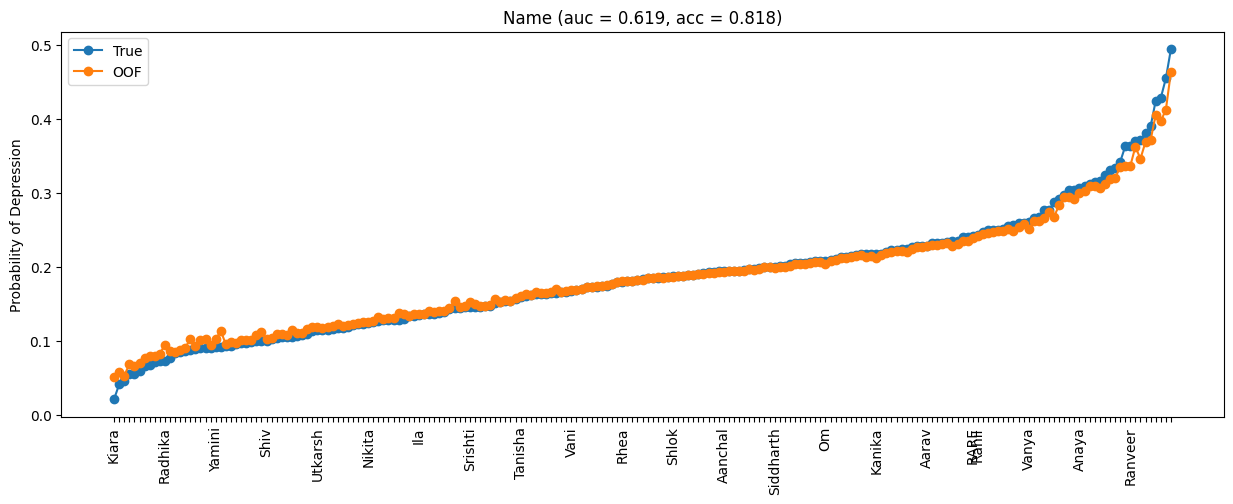

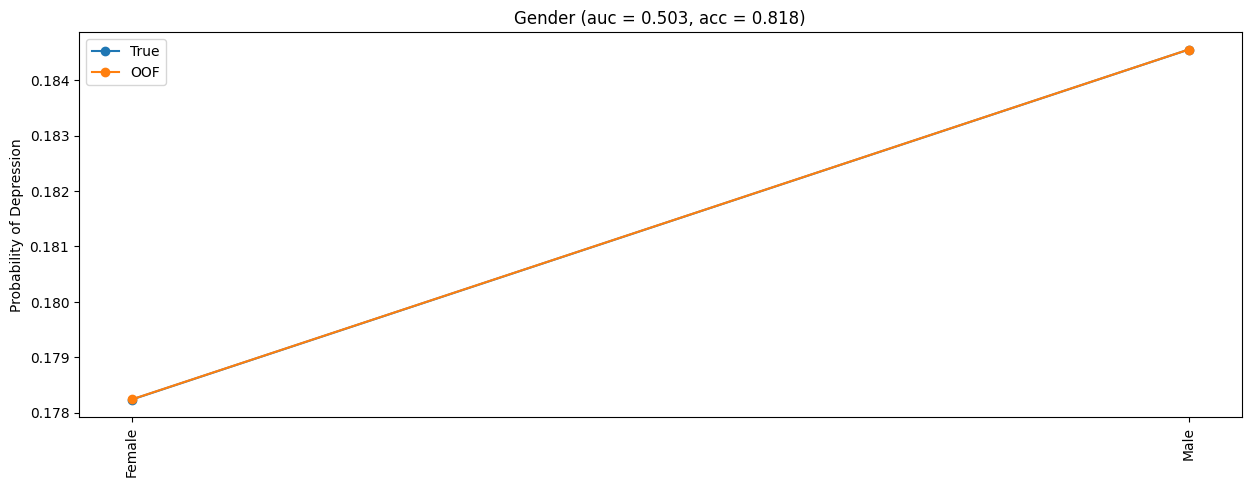

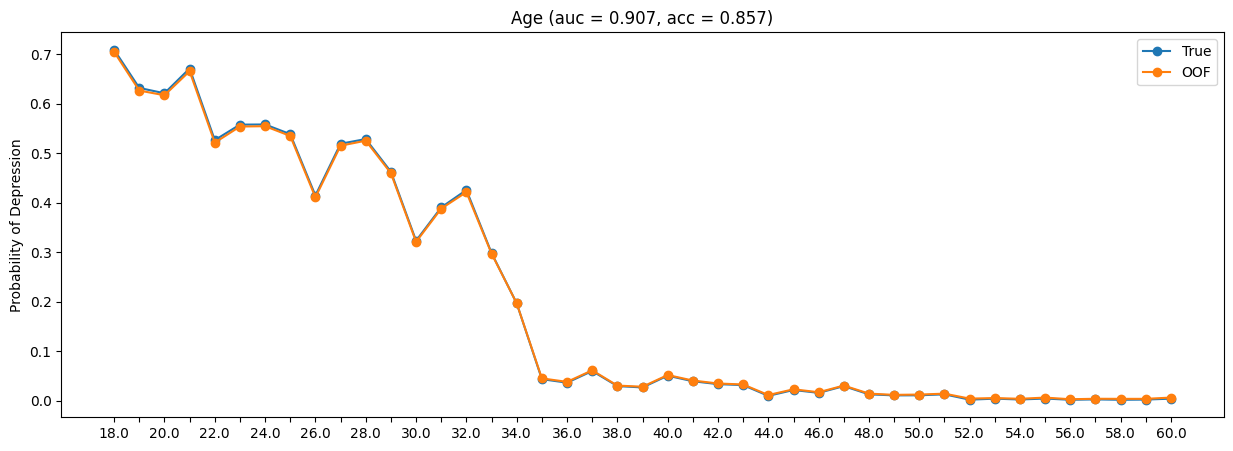

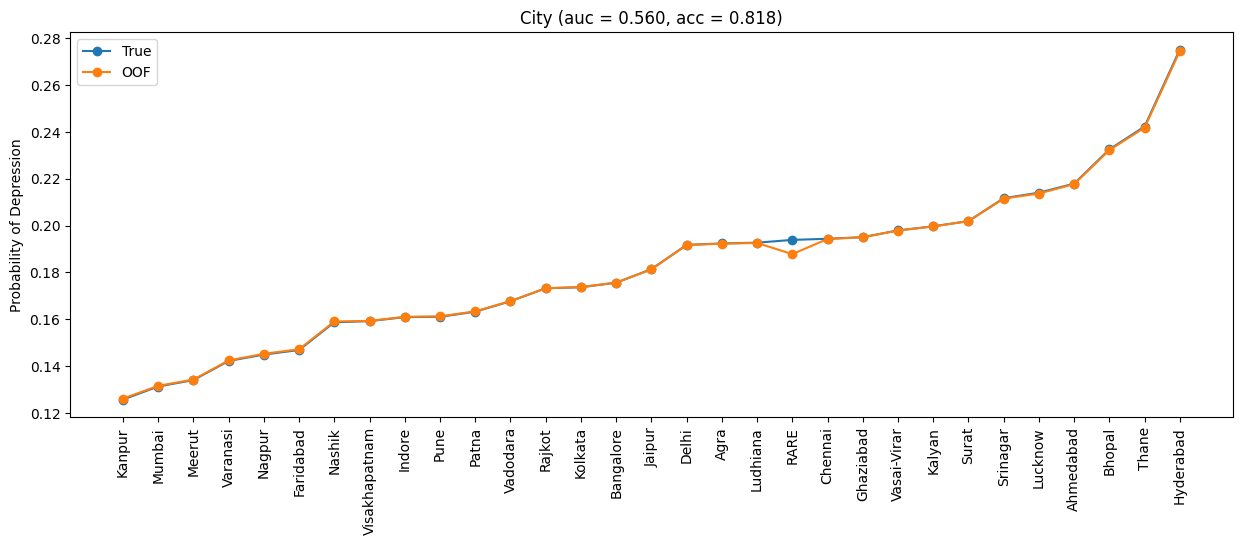

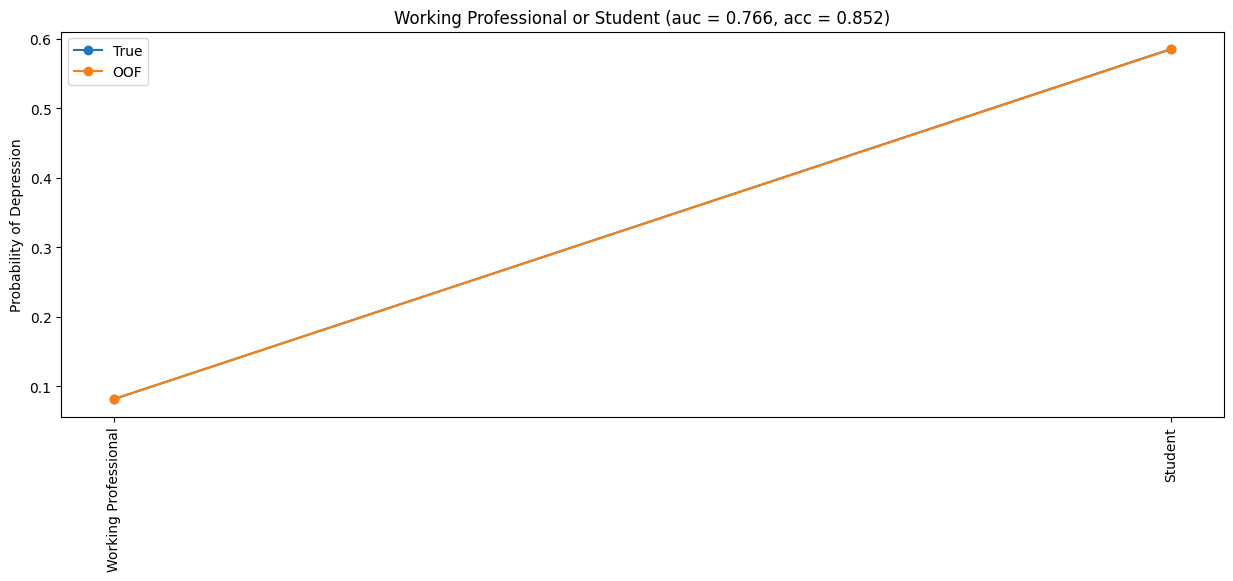

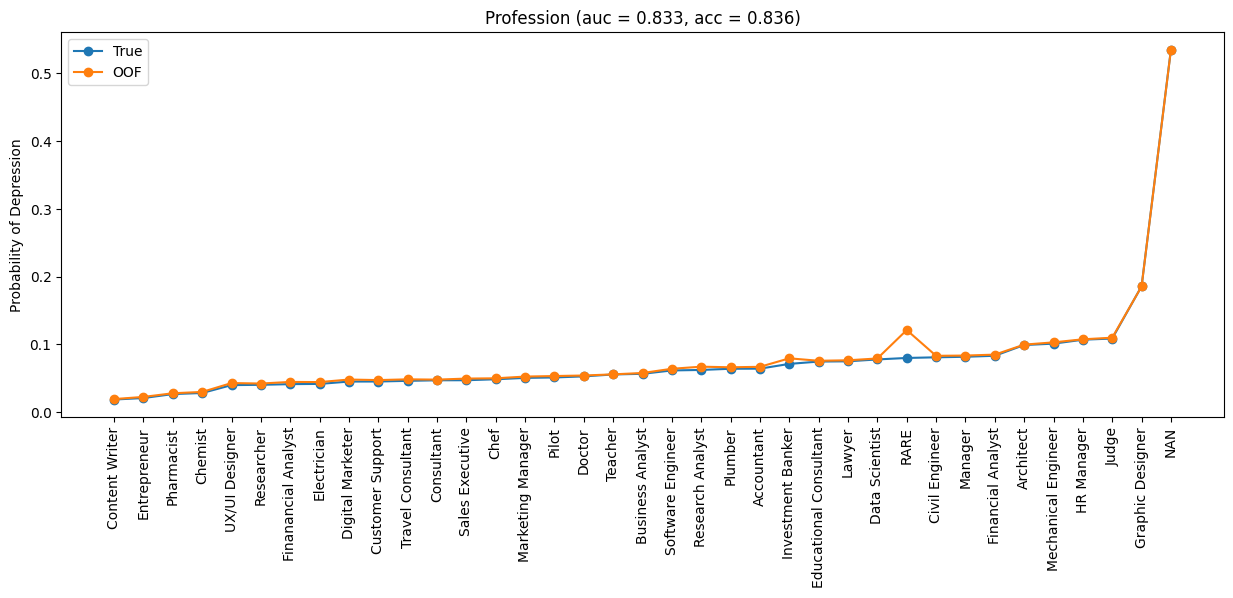

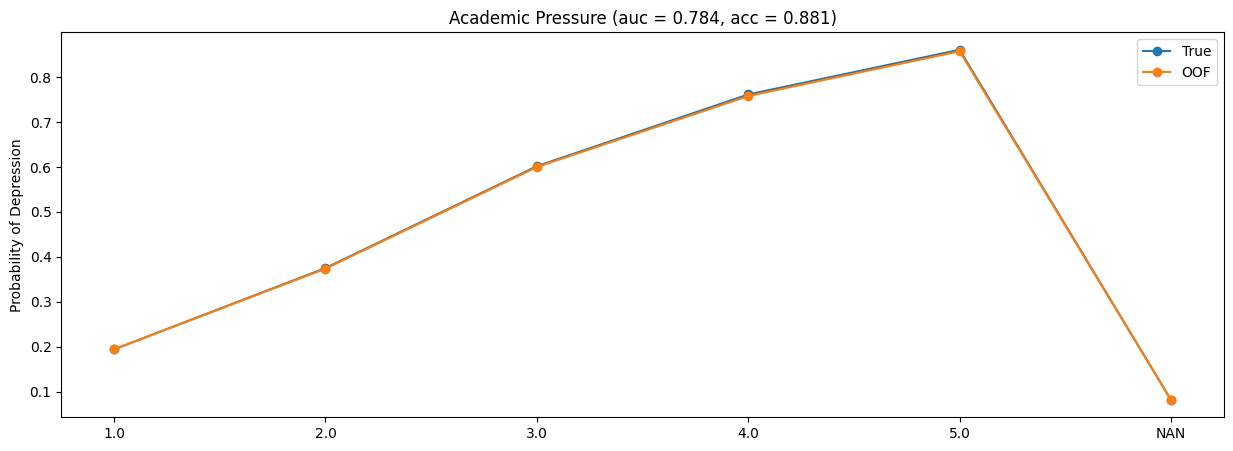

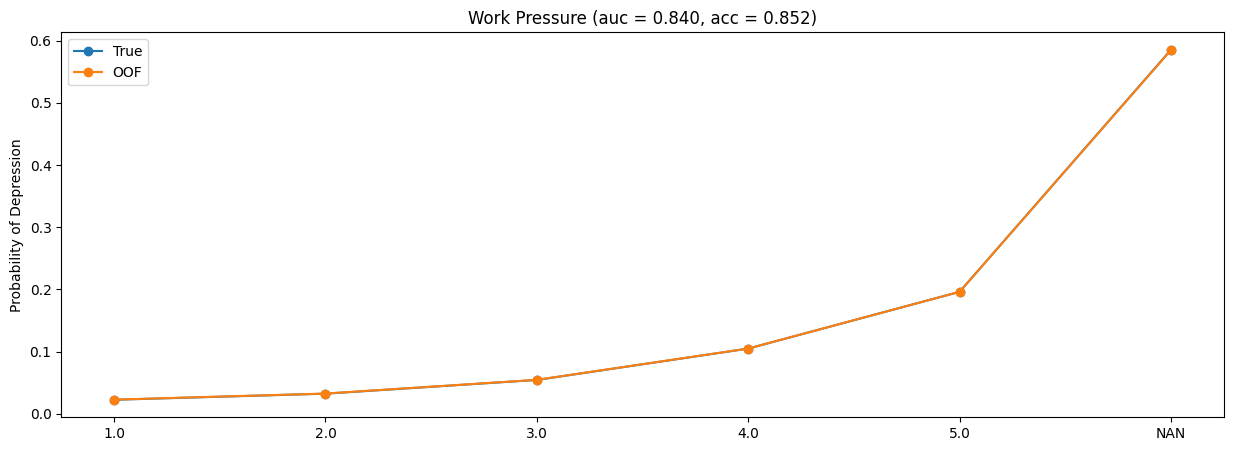

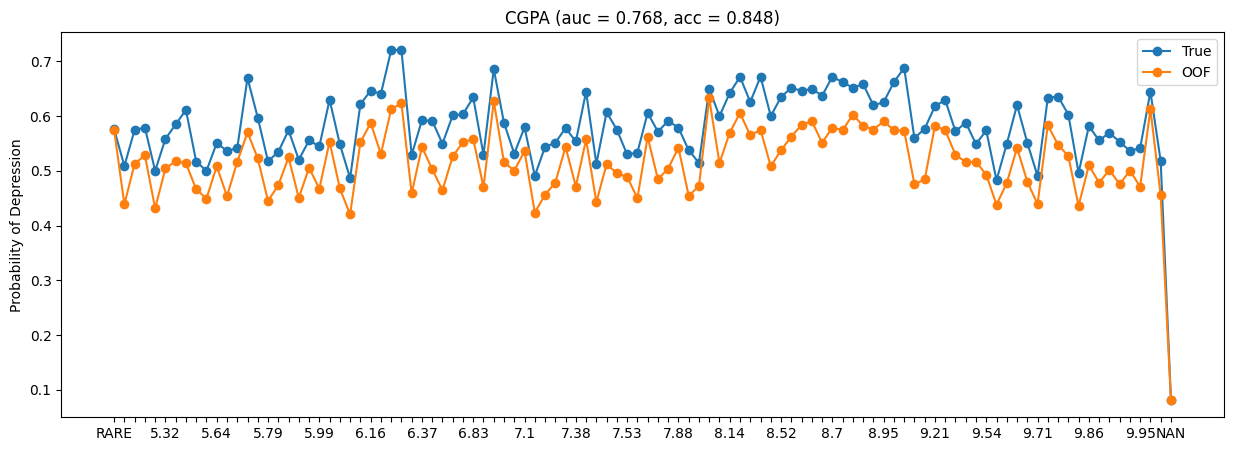

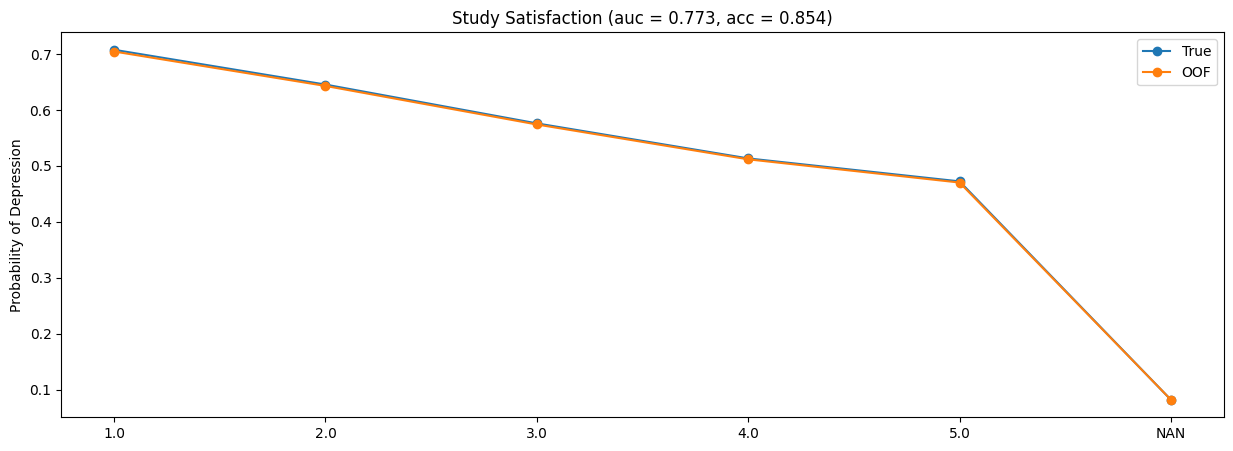

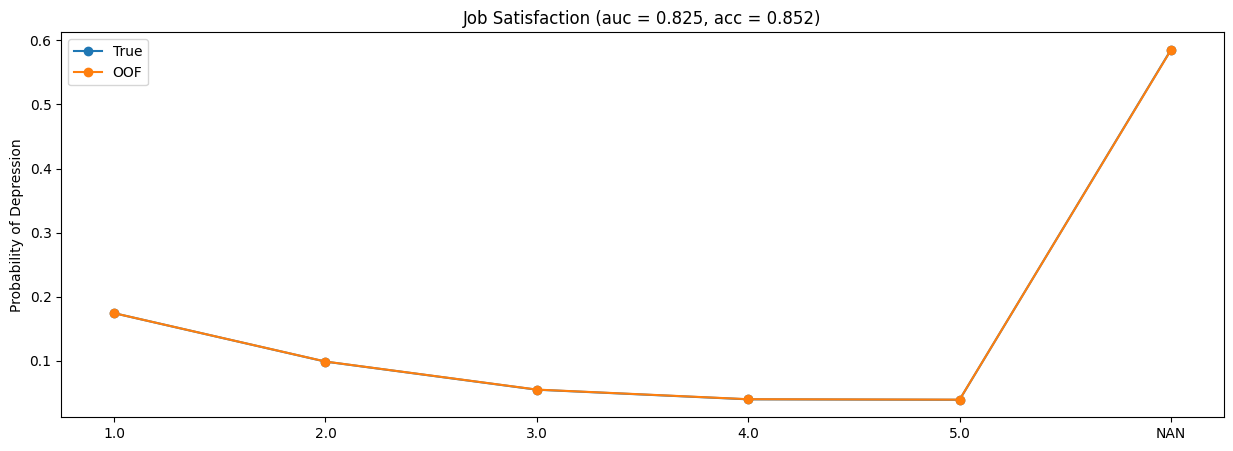

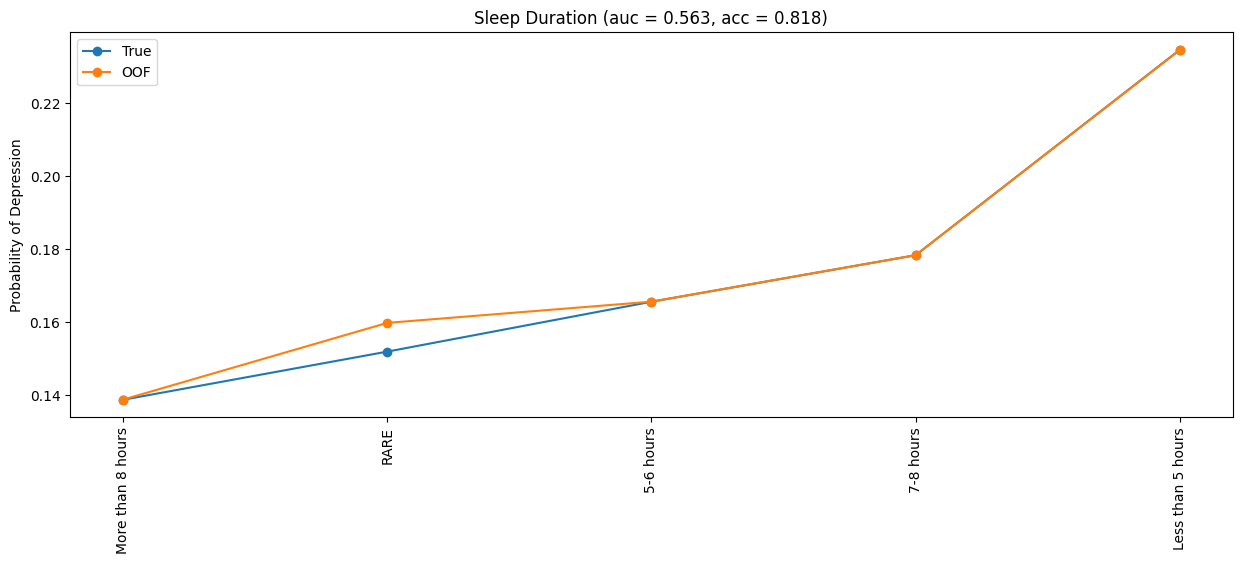

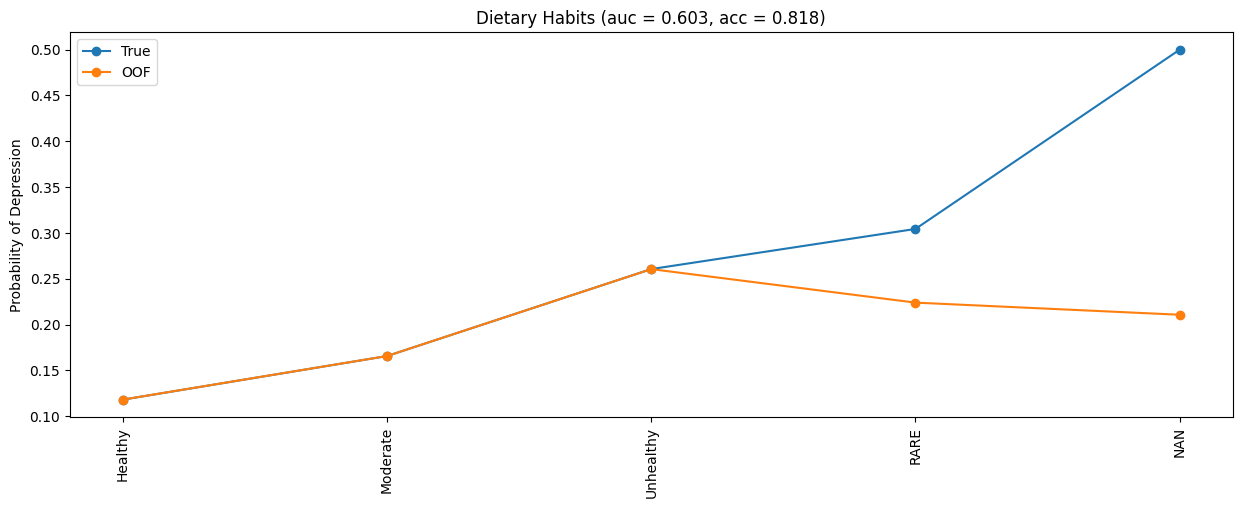

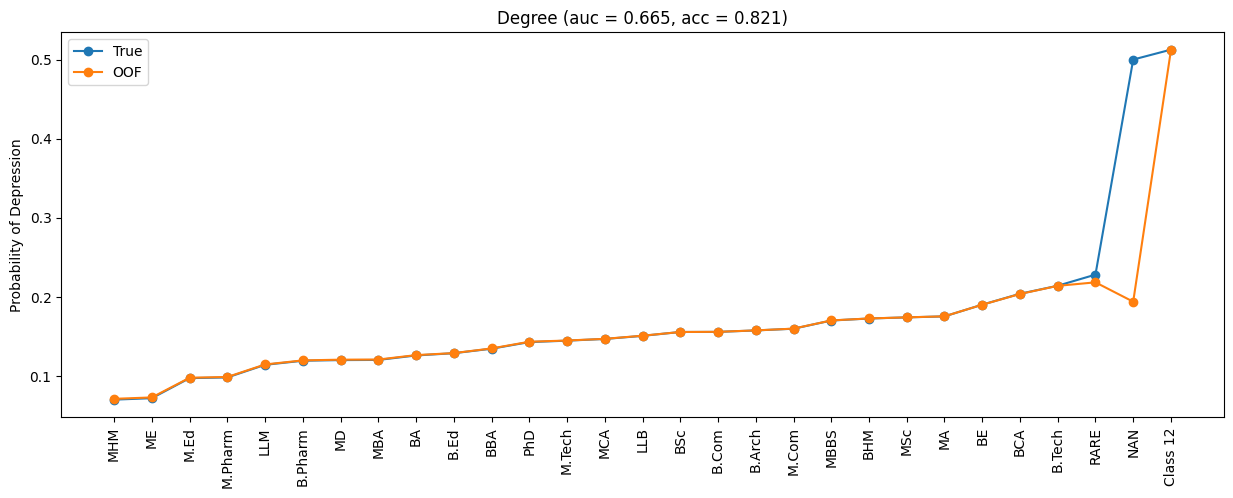

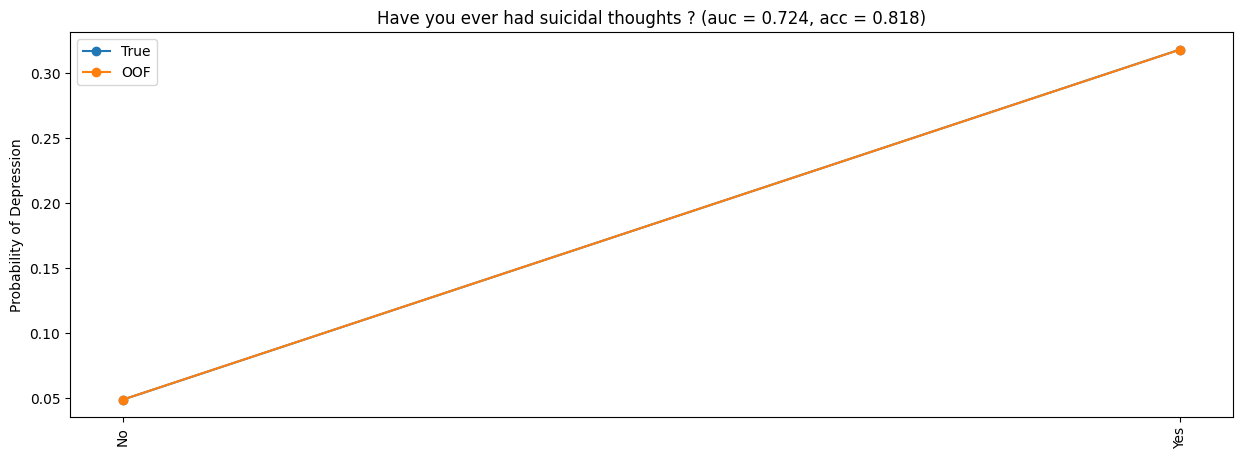

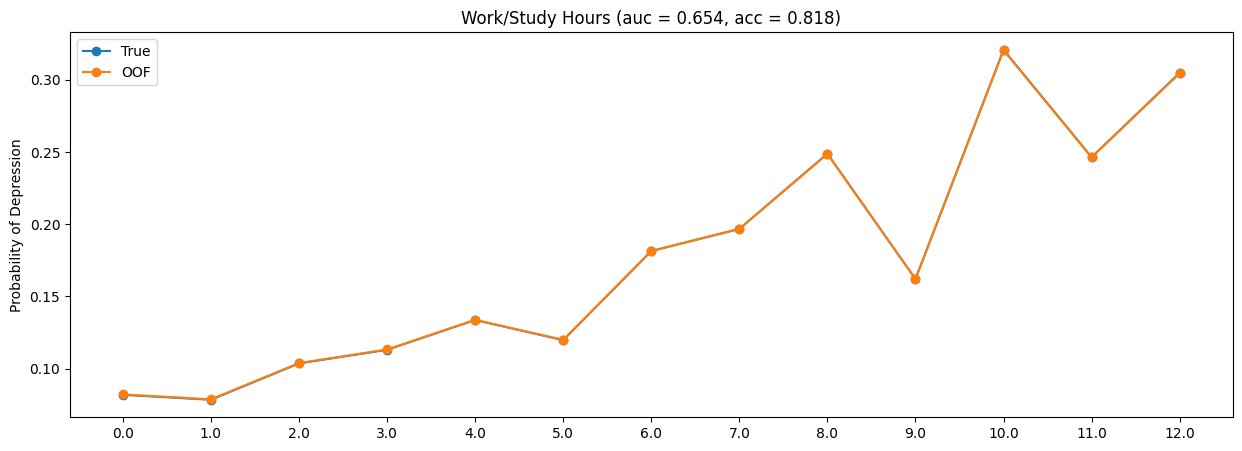

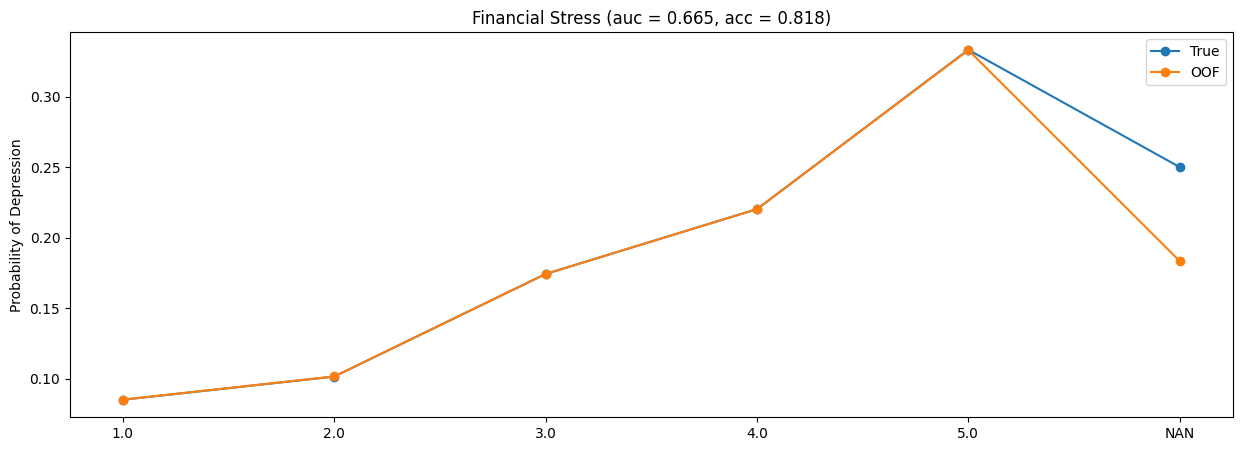

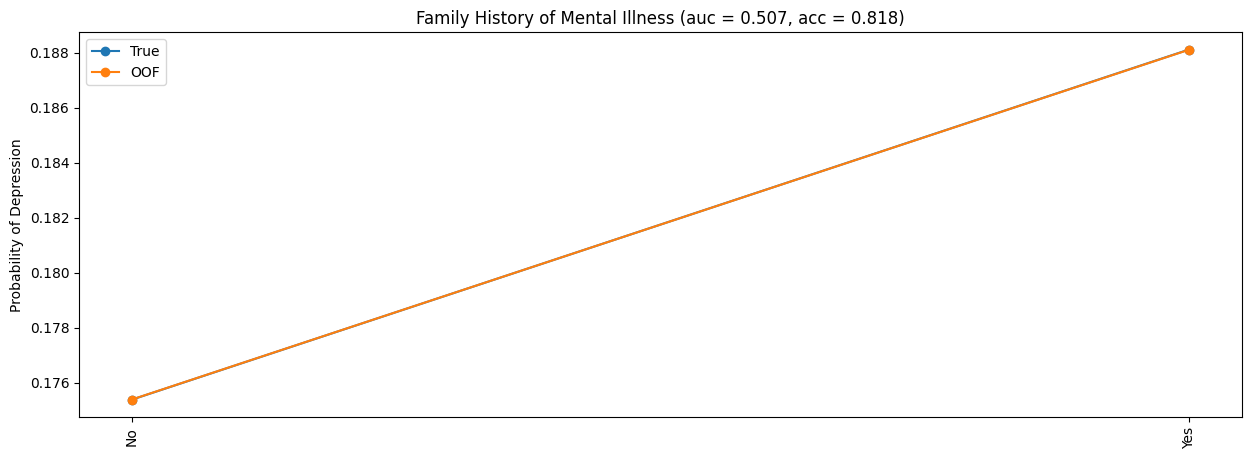

In [6]:
for COL in FEATURES:

    # COMPUTE TRUE AND OOF MEANS FOR CATEGORICAL VALUE
    tmp = train.groupby(COL).Depression.mean()
    train["oof"] = oofs[COL]
    tmp2 = train.groupby(COL).oof.mean()
    
    plt.figure(figsize=(15,5))

    # ORDER LABELS ON X AXIS
    if COL_TYPES[COL] == "object":
        tmp = tmp.sort_values()
        tmp2 = tmp2.reindex(tmp.index)
        plt.xticks(rotation=90)
    else:
        numeric_part = [x for x in tmp.index if x.replace(".", "", 1).isdigit()]
        sorted_index = sorted(numeric_part, key=float)
        if COL!="Age": sorted_index = ["RARE"] + sorted_index + ["NAN"]
        tmp = tmp.reindex(sorted_index)
        tmp2 = tmp2.reindex(sorted_index)

    # IF TOO MANY X TICKS SKIP DISPLAYING SOME
    xticks = list(tmp.index)
    skip = len(xticks)//20
    if skip>0: xticks = xticks[::skip]
    plt.xticks(
        ticks=range(len(tmp)),  
        labels=[label if label in xticks+["RARE","NAN"] else "" for label in tmp.index],  
    )

    # PLOT
    plt.plot(tmp,'-o',label="True")
    plt.plot(tmp2,'-o',label="OOF")
    acc = df.loc[df.feature==COL,"acc"].values[0]
    auc = df.loc[df.feature==COL,"auc"].values[0]
    plt.title(f"{COL} (auc = {auc:.3f}, acc = {acc:.3f})")
    plt.ylabel("Probability of Depression")
    #plt.xlabel(f"Value of {COL}")
    plt.legend()
    plt.show()

# Hill Climbing
We use the hill climbing code from my old Kaggle notebook [here][1]. We update the inner for-loop to utilize GPU and vectorization. This makes it faster than the original notebook and we can probably do more updates to increase the speed more.

We hill climb using `AUC` as a proxy for `ACC`, this is because `ACC` is not smooth and doesn't climb well. Furthermore, we convert probabilities into log odds before combining models. Afterward the result is not probability calibrated and we need to search for a prediction threshold (i.e. threadhold=0.5 does not work well). 

Since the training data has 18.17% target=1, we just assume that the top 18.17% predictions should be 1 (and the others 0). And pick the threshold that way. (When computing the overall ACC after hill climbing finishes and when picking test predictions later).

[1]: https://www.kaggle.com/code/cdeotte/public-lb-1st-place-solution

## Find Best Single Model

In [7]:
def compute_metric_auc(p):
    auc = roc_auc_score(train.Depression.values, p)
    return auc

In [8]:
# LOAD ALL OOF
files = FEATURES
x_train = []
for f in files:
    x_train.append(oofs[f])
x_train = np.clip(1e-15,1-1e-15,np.stack(x_train).T) # OOF MUST BE 0<PROBS<1
print("Our combined OOF have shape:",x_train.shape)

Our combined OOF have shape: (140700, 18)


In [9]:
# COMPUTE METRIC FOR EACH OOF
best_score = 0
best_index = -1

for k,name in enumerate( files ):
    s = compute_metric_auc(x_train[:,k])
    if s > best_score:
        best_score = s
        best_index = k
    print(f'AUC {s:0.3f} {name}') 
print()
print(f'Best single model is {files[best_index]} with AUC = {best_score:0.3f}')

AUC 0.619 Name
AUC 0.503 Gender
AUC 0.907 Age
AUC 0.560 City
AUC 0.766 Working Professional or Student
AUC 0.833 Profession
AUC 0.784 Academic Pressure
AUC 0.840 Work Pressure
AUC 0.768 CGPA
AUC 0.773 Study Satisfaction
AUC 0.825 Job Satisfaction
AUC 0.563 Sleep Duration
AUC 0.603 Dietary Habits
AUC 0.665 Degree
AUC 0.724 Have you ever had suicidal thoughts ?
AUC 0.654 Work/Study Hours
AUC 0.665 Financial Stress
AUC 0.507 Family History of Mental Illness

Best single model is Age with AUC = 0.907


## Begin Hill Climbing

In [10]:
import cupy as cp, gc

def multiple_roc_auc_scores(actual, predicted):
    """
    Computes multiple approximate AUC scores using GPU.
    
    This function calculates K approximate AUC scores simultaneously for a binary classification 
    problem. The implementation does not handle ties in predictions correctly, making it an 
    approximate AUC computation. The function is based on the algorithm outlined in:
    https://github.com/benhamner/Metrics/blob/master/R/R/metrics.r

    Parameters:
    ----------
    actual : cupy.ndarray
        A 1D GPU array of shape (N,), where N is the number of samples. 
        Contains binary values (0 or 1) indicating the true labels.
    
    predicted : cupy.ndarray
        A 2D GPU array of shape (N, K), where K is the number of classifiers.
        Each column contains predicted scores for the corresponding classifier.

    Returns:
    -------
    cupy.ndarray
        A 1D GPU array of shape (K,) containing the AUC scores for each classifier.

    """
    n_pos = cp.sum(actual)  # Number of positive samples (on GPU)
    n_neg = len(actual) - n_pos  # Number of negative samples (on GPU)
    ranked = cp.argsort(cp.argsort(predicted, axis=0), axis=0) + 1  # Ranks for each column (on GPU)
    aucs = (cp.sum(ranked[actual == 1, :], axis=0) - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)  # AUC computation
    return aucs  # AUC scores for each classifier (on GPU)

In [11]:
USE_NEGATIVE_WGT = True
MAX_MODELS = 1000
TOL = 1e-5

indices = [best_index]
old_best_score = best_score

# PREPARE/MOVE VARIABLES TO GPU FOR SPEED UP
x_train2 = cp.array( np.log( x_train/(1-x_train) ) ) #GPU LOGITS 
best_ensemble = x_train2[:,best_index] # GPU
truth = cp.array( train.Depression.values ) # GPU
start = -0.50
if not USE_NEGATIVE_WGT: start = 0.01
ww = cp.arange(start,0.51,0.01) # GPU
nn = len(ww)

# BEGIN HILL CLIMBING
models = [best_index]
weights = []
metrics = [best_score]

for kk in range(1_000_000):

    best_score = 0
    best_index = -1
    best_weight = 0

    # TRY ADDING ONE MORE MODEL
    for k,ff in enumerate(files):
        new_model = x_train2[:,k] # GPU
        m1 = cp.repeat(best_ensemble[:, cp.newaxis], nn, axis=1) * (1-ww) # GPU
        m2 = cp.repeat(new_model[:, cp.newaxis], nn, axis=1) * ww # GPU
        mm = m1+m2 # GPU
        #mm = 1 / (1 + cp.exp(-mm)) # GPU (convert logits to probs - not needed for auc)
        new_aucs = multiple_roc_auc_scores(truth, mm)
        new_score = cp.max(new_aucs).item() # GPU -> CPU
        if new_score > best_score:
            best_score = new_score # CPU
            best_index = k # CPU
            ii = np.argmax(new_aucs).item() # GPU -> CPU
            best_weight = ww[ii].item() # GPU -> CPU
            potential_ensemble = mm[:,ii] # GPU
    del new_model, m1, m2, mm, new_aucs, new_score
    gc.collect()

    # STOPPING CRITERIA
    indices.append(best_index)
    indices = list(np.unique(indices))
    if len(indices)>MAX_MODELS:
        print(f'=> We reached {MAX_MODELS} models')
        indices = indices[:-1]
        break
    if best_score - old_best_score < TOL: 
        print(f'=> We reached tolerance {TOL}')
        break

    # RECORD NEW RESULT
    print(kk,'New best AUC',best_score,f'adding "{files[best_index]}"','with weight',f'{best_weight:0.3f}')
    models.append(best_index)
    weights.append(best_weight)
    metrics.append(best_score)
    best_ensemble = potential_ensemble
    old_best_score = best_score

0 New best AUC 0.943520644995852 adding "Have you ever had suicidal thoughts ?" with weight 0.490
1 New best AUC 0.95308858365188 adding "Financial Stress" with weight 0.360
2 New best AUC 0.9605366107950805 adding "Academic Pressure" with weight 0.140
3 New best AUC 0.9631334595341929 adding "Work/Study Hours" with weight 0.190
4 New best AUC 0.9651484663614787 adding "Dietary Habits" with weight 0.200
5 New best AUC 0.9659608551385422 adding "Sleep Duration" with weight 0.170
6 New best AUC 0.9664156392597418 adding "Age" with weight -0.030
7 New best AUC 0.9667831827477232 adding "Working Professional or Student" with weight -0.020
8 New best AUC 0.9675852871979926 adding "Work Pressure" with weight 0.030
9 New best AUC 0.9684279014936218 adding "Working Professional or Student" with weight -0.030
10 New best AUC 0.9687951395738211 adding "Work Pressure" with weight 0.020
11 New best AUC 0.9692581870308296 adding "Working Professional or Student" with weight -0.030
12 New best AUC 0

# Compute Hill Climb ACC

In [12]:
def compute_metric_acc(p):
    t = np.partition(p, -25567)[-25567]
    p = (p >= t).astype(int)
    acc = accuracy_score(train.Depression.values, p)
    return acc

acc = compute_metric_acc(best_ensemble.get())
auc = compute_metric_auc(best_ensemble.get())
print(f"Overall Hill climbing ACC = {acc:.3f}")
print(f"Overall Hill climbing AUC = {auc:.3f}")

Overall Hill climbing ACC = 0.938
Overall Hill climbing AUC = 0.975


# Compute Weights Per Model
Above we may have added the same model more than once. So below we consolidate all updates and compute a unique weight for each OOF model. We can use the weights below to understand our explainable model. When making a test prediction the weights below indicate how we combine all the individual features which are displayed in the prevous plots.

In [13]:
wgt = np.array([1])
for w in weights:
    wgt = wgt*(1-w)
    wgt = np.concatenate([wgt,np.array([w])])
    
rows = []
t = 0
for m,w,s in zip(models,wgt,metrics):
    name = files[m]
    dd = {}
    dd['weight'] = w
    dd['model'] = name
    rows.append(dd)
    t += float( f'{w:.3f}' )

# DISPLAY WEIGHT PER MODEL
df = pd.DataFrame(rows)
df = df.groupby('model').agg('sum').reset_index().sort_values('weight',ascending=False)
df = df.reset_index(drop=True)
df

,model,weight
0,Family History of Mental Illness,0.244576
1,Financial Stress,0.130840
2,Sleep Duration,0.122776
3,Have you ever had suicidal thoughts ?,0.115149
4,Dietary Habits,0.111527
5,Academic Pressure,0.107147
6,Work/Study Hours,0.091914
7,Job Satisfaction,0.091246
8,Age,0.089169
9,Work Pressure,0.085662


In [14]:
# SANITY CHECK
print('Ensemble weights sum to',df.weight.sum())

Ensemble weights sum to 1.0000000000000009


# Verify Ensemble Weights
Sanity check verifying that the weights computed above produce our best hill climbing ACC.

In [15]:
# COMBINE OOF PREDITIONS (using weights from hill climbing)
x_map = {x:y for x,y in zip(files,np.arange(len(files)))}
x_train3 = x_train2.get()
ensemble = x_train3[:, x_map[df.model.iloc[0]] ] * df.weight.iloc[0]
for k in range(1,len(df)):
    ensemble += x_train3[:, x_map[df.model.iloc[k]] ] * df.weight.iloc[k]
m = compute_metric_acc(ensemble)
print(f'Overall Hill climbing ACC = {m:0.3f}')

Overall Hill climbing ACC = 0.938


# Make Test Submission
We assume that the test data has the same `18.17%` positive targets as the train data. (Since both are random halves of Kaggle's 200k generated synthetic data this is a safe assumption). Therefore we set our greatest `18.17%` test predictions to 1 and the other predictions to 0. 

In [16]:
# LOAD TEST PREDICTIONS
x_test = []
for f in files:
    p = np.clip(1e-15,1-1e-15,preds[f]) # PREDS MUST BE 0<PROBS<1
    p = np.log( p/(1-p) ) # LOG ODDS
    x_test.append(p)
x_test = np.stack(x_test).T
print( x_test.shape )

# COMBINE TEST PREDITIONS (using weights from hill climbing)
x_map = {x:y for x,y in zip(files,np.arange(len(files)))}
pred = x_test[:, x_map[df.model.iloc[0]] ] * df.weight.iloc[0]
for k in range(1,len(df)):
    pred += x_test[:, x_map[df.model.iloc[k]] ] * df.weight.iloc[k]

(93800, 18)


In [17]:
global_mean = train.Depression.mean()
test_positive = int( len(pred)*global_mean ) 
print(f"Train global target mean is {global_mean}")
print(f"Therefore we need {test_positive} positive test predictions...")
t = np.partition(pred, -test_positive)[-test_positive]
pred = (pred >= t).astype(int)
print(f"We found {pred.sum()} positive test predictions")

Train global target mean is 0.18171286425017769
Therefore we need 17044 positive test predictions...
We found 17044 positive test predictions


In [18]:
# WRITE SUB TO CSV
sub = pd.read_csv("/kaggle/input/playground-series-s4e11/sample_submission.csv")
sub.Depression = pred
print("Test shape", sub.shape )
print("Test target mean is", sub.Depression.mean())
sub.to_csv(f"submission.csv",index=False)
sub.head()

Test shape (93800, 2)
Test target mean is 0.18170575692963753


,id,Depression
0,140700,0
1,140701,0
2,140702,0
3,140703,1
4,140704,0
